<a href="https://colab.research.google.com/github/UygarUsta/Codes/blob/main/KeyPointSavedModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive 
drive.mount("/content/Drive")

Mounted at /content/Drive


In [ ]:
!unzip /content/Drive/MyDrive/keypoint_plates.zip

In [3]:
import json
import os


In [4]:
# # Set the directory containing the JSON files
json_dir = "/content/images/"

# Create an empty list to store the points
points = []

# Iterate over the JSON files in the directory
for file in os.listdir(json_dir):
  points = []
  if file.endswith(".json"):
    # Load the JSON file
    with open(os.path.join(json_dir, file), "r") as f:
        json_obj = json.load(f)

    # Extract the points from the JSON object
    for shape in json_obj["shapes"]:
        x = int(shape["points"][0][0])
        y = int(shape["points"][0][1])
        points.append(x)
        points.append(y)
    #print(len(points))
    if len(points) != 8:
      os.remove(json_dir+file)
      os.remove(json_dir+file.replace(".json",".jpg"))


In [5]:
import cv2 
import glob
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import numpy as np

In [6]:
glob_img = sorted(glob.glob("/content/images/*.jpg"))
glob_json = sorted(glob.glob("/content/images/*.json"))

In [7]:
len(glob_img) == len(glob_json)

True

In [66]:
class KeypointDataset(Dataset):
  def __init__(self, images, keypoints):

    self.images = images
    self.keypoints = keypoints

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    points_ = []
    image = self.images[idx]
    keypoint_ = self.keypoints[idx]
    image = cv2.imread(image,0)
    h,w = image.shape[0],image.shape[1]
    image = cv2.resize(image,(256,256))
    image = torch.tensor(image/255.)
    #print(keypoint_)
    with open(keypoint_,"r") as f:
      json_obj = json.load(f)
      for shape in json_obj["shapes"]:
          x = int(shape["points"][0][0])
          y = int(shape["points"][0][1])
          points_.append((x/w)*256)
          points_.append((y/h)*256)


    keypoint = torch.tensor(points_) / 256.
    #print(keypoint)
    return image, keypoint

In [67]:
dataset = KeypointDataset(glob_img, glob_json)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [68]:
im,kp = next(iter(dataloader))

In [69]:
class KeypointModel(nn.Module):
    def __init__(self, num_keypoints):
        super(KeypointModel, self).__init__()
        self.num_keypoints = num_keypoints
        self.pool = nn.MaxPool2d(2)
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(18432, 1028)
        self.fc2 = nn.Linear(1028, 256)
        self.fc3 = nn.Linear(256, self.num_keypoints * 2)

    def forward(self, x):
        x = torch.relu(self.pool(self.conv1(x)))
        x = torch.relu(self.pool(self.conv2(x)))
        x = torch.relu(self.pool(self.conv3(x)))
        x = torch.relu(self.pool(self.conv4(x)))
        x = torch.relu(self.pool(self.conv5(x)))
        #print(x.shape)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        #x = x.view(x.size(0), self.num_keypoints * 2)
        return x

In [79]:
num_epochs = 300
device = "cuda"
model = KeypointModel(num_keypoints=4)
if torch.cuda.is_available():
    model.cuda()

# Define a loss function and an optimizer
loss_fn = nn.MSELoss()
#loss_fn = 
optimizer = torch.optim.Adam(model.parameters(),weight_decay=1e-5)

loss_tracker = None
# Train the model
for epoch in range(num_epochs):
    print(f"Epoch {epoch}/{num_epochs}")
    loss_ep = 0.0
    for images, keypoints in dataloader:
        # Forward pass
        predicted_keypoints = model(images.to(device).float()[:,None])
        loss = loss_fn(predicted_keypoints, keypoints.to(device))

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        # Update the weights
        optimizer.step()
        loss_ep += loss.item()

    loss_ep /= len(images)
    if loss_tracker == None:
      loss_tracker = loss_ep
    if loss_ep < loss_tracker:
      loss_tracker = loss_ep
      torch.save(model,f"kp_ep_normalized.pt")
      print("Saved torch model")
    print("Epoch Loss:",loss_ep)


Epoch 0/300
Epoch Loss: 0.4543244970962405
Epoch 1/300
Saved torch model
Epoch Loss: 0.06784606603905559
Epoch 2/300
Saved torch model
Epoch Loss: 0.015481985453516246
Epoch 3/300
Saved torch model
Epoch Loss: 0.007533446513116359
Epoch 4/300
Saved torch model
Epoch Loss: 0.005595462257042527
Epoch 5/300
Saved torch model
Epoch Loss: 0.005093372333794833
Epoch 6/300
Epoch Loss: 0.005395912961103022
Epoch 7/300
Saved torch model
Epoch Loss: 0.005037524527870119
Epoch 8/300
Saved torch model
Epoch Loss: 0.004994190577417612
Epoch 9/300
Epoch Loss: 0.005213758675381541
Epoch 10/300
Epoch Loss: 0.0052333981031551955
Epoch 11/300
Epoch Loss: 0.0050380989909172055
Epoch 12/300
Epoch Loss: 0.005117551004514098
Epoch 13/300
Epoch Loss: 0.005013081850484014
Epoch 14/300
Epoch Loss: 0.00508381009567529
Epoch 15/300
Epoch Loss: 0.005228022998198867
Epoch 16/300
Saved torch model
Epoch Loss: 0.004954982316121459
Epoch 17/300
Epoch Loss: 0.004963775305077434
Epoch 18/300
Epoch Loss: 0.0049793684389

In [ ]:
#torch.save(model, 'kp_saved_model.pt')

In [80]:
model3 = torch.load("/content/kp_ep_normalized.pt")

In [81]:
model3.to(device)

KeypointModel(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=18432, out_features=1028, bias=True)
  (fc2): Linear(in_features=1028, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=8, bias=True)
)

In [82]:
def predictor(img_path):
  global im_
  global res 
  im = cv2.imread(img_path,0)
  im = cv2.resize(im,(256,256))
  im = torch.tensor(im[None][None]) / 255.
  model3.eval()
  res = model3(im.float().to(device)) * 256
  im_ = im[0][0].cpu().numpy() * 255.
  cv2.circle(im_, (int(res[0][0]),int(res[0][1])), 3, (255,255,0), 2)
  cv2.circle(im_, (int(res[0][2]),int(res[0][3])), 3, (255,255,0), 2)
  cv2.circle(im_, (int(res[0][4]),int(res[0][5])), 3, (255,255,0), 2)
  cv2.circle(im_, (int(res[0][6]),int(res[0][7])), 3, (255,255,0), 2)
  plt.imshow(im_,cmap="gray")

In [95]:
def warp():
  global res_
  global result
  res_ = []
  for k in range(0,len(res[0]),2):
    f = []
    f.append(int(res[0][k]))
    f.append(int(res[0][k+1]))
    res_.append(f)
  res_ = np.array(res_,dtype=np.float32)
  w,h = 256,128
  box2 = np.array([(0, 0), (w, 0), (w, h), (0, h)])
  M = cv2.getPerspectiveTransform(res_, box2.astype(np.float32))
  result = cv2.warpPerspective(im_, M, (w, h))
  plt.imshow(result,cmap="gray")

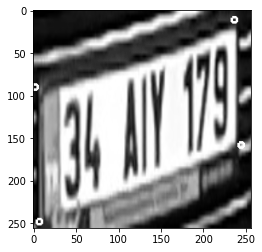

In [96]:
predictor("/content/plate3.jpg")

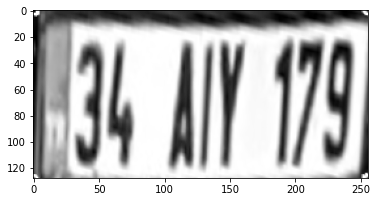

In [97]:
warp()

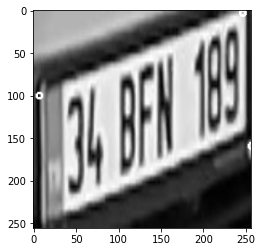

In [98]:
predictor("/content/plate1.jpg")

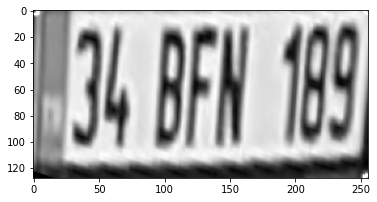

In [99]:
warp()

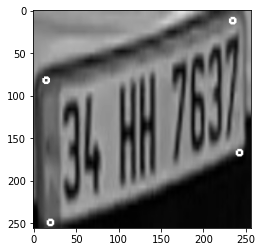

In [100]:
predictor("/content/plate0.jpg")

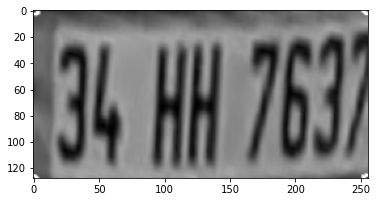

In [101]:
warp()

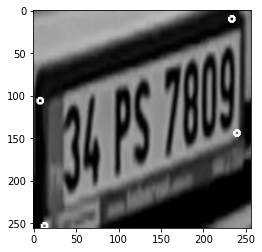

In [102]:
predictor("/content/plate4.jpg")

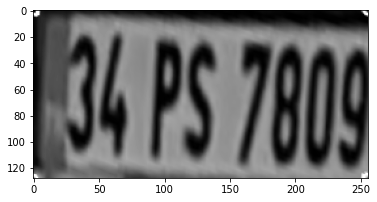

In [103]:
warp()

In [ ]:
import time

In [ ]:
# %timeit predictor("/content/s.jpg")

In [ ]:
# for i in range(30):
#   t1 = time.time()
#   im = cv2.imread("/content/s.jpg",0)
#   im = cv2.resize(im,(256,256))
#   im = torch.tensor(im[None][None])
#   model3.eval()
#   m_t = time.time()
#   res = model3(im.float().to(device))
#   m_f = time.time()
#   im_ = im[0][0].cpu().numpy()
#   cv2.circle(im_, (int(res[0][0]),int(res[0][1])), 3, (255,255,0), 2)
#   cv2.circle(im_, (int(res[0][2]),int(res[0][3])), 3, (255,255,0), 2)
#   cv2.circle(im_, (int(res[0][4]),int(res[0][5])), 3, (255,255,0), 2)
#   cv2.circle(im_, (int(res[0][6]),int(res[0][7])), 3, (255,255,0), 2)
#   plt.imshow(im_,cmap="gray")
#   t2 = time.time()
#   print(t2-t1)
#   print("model time:",m_f-m_t)

In [ ]:
# 1/0.0017

In [ ]:
###C++ EQ of warp part

#include <opencv2/opencv.hpp>
#include <opencv2/core/core.hpp>
#include <opencv2/imgproc/imgproc.hpp>

#include <iostream>
#include <vector>

# using namespace cv;
# using namespace std;

# int main()
# {
#     // Load the image
#     Mat im_ = imread("image.jpg");

#     // Convert the image to a float32 array
#     Mat res_ = Mat(im_.rows, im_.cols, CV_32FC1);
#     im_.convertTo(res_, CV_32FC1);

#     // Define the width and height of the output image
#     int w = 256;
#     int h = 256;

#     // Define the destination box for the perspective transform
#     vector<Point2f> box2 { Point2f(0, 0), Point2f(w, 0), Point2f(w, h), Point2f(0, h) };

#     // Calculate the perspective transform matrix
#     Mat M = getPerspectiveTransform(res_, box2);

#     // Warp the image using the perspective transform matrix
#     Mat result;
#     warpPerspective(im_, result, M, Size(w, h));

#     // Save the result
#     imwrite("result.jpg", result);

#     return 0;
# }


In [88]:
!cp /content/kp_ep_normalized.pt /content/Drive/MyDrive/kp_ep_normalized.pt